# Info
Purpose:

    Explore some MODIS cloud fraction and subsequent fire counts

Input:

    None

Output:

    Figure and save files

Keywords:

    none

Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
    - Sp_parameters
    - write_utils
    - path_utils
    - hdf5storage
    - scipy

Needed Files:
  - MYD06 and MYD14 hdf files

Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2021-05-11
    Modified:


# Prepare python environment

In [1]:
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
import write_utils as wu
from path_utils import getpath
import hdf5storage as hs
import scipy.io as sio
import matplotlib.pyplot as plt

import os
from mpl_toolkits.basemap import Basemap
%matplotlib notebook

In [11]:
%matplotlib notebook

In [2]:
name = 'FOG2FIRE'
vv = 'v1'
fp = getpath(name)


Return path named:  FOG2FIRE /data/sam/FOG2FIRE/


# Load files

## Load the Cloud files

In [3]:
lc = os.listdir(fp+'MYD06/')

# Plan out the regions

In [41]:
def make_map(ax=plt.gca()):
    m = Basemap(projection='stere',lon_0=-122.0,lat_0=38.0,
            llcrnrlon=-131.0, llcrnrlat=32.0,
            urcrnrlon=-108.0, urcrnrlat=48,resolution='i',ax=ax)
    m.drawcoastlines()
    #m.fillcontinents(color='#AAAAAA')
    m.drawstates()
    m.drawcountries()
    m.drawmeridians(np.linspace(-131,-108,6),labels=[0,0,0,1])
    m.drawparallels(np.linspace(31,48,9),labels=[1,0,0,0])
    def format_coord(x, y):
        return 'x=%.4f, y=%.4f'%(m(x, y, inverse = True))
    ax.format_coord = format_coord
    return m
make_map()

#m.plot([-125,-119,-119,-125,-125],[42,42,38.5,38.5,42],latlon=True,color='r')

In [43]:
rgs = [[[32.5,-121.5],[35.5,-117.0]],
       [[32.5,-117.0],[35.5,-114.0]],
       [[35.5,-123.5],[38.5,-120.8]],
       [[35.5,-120.8],[38.5,-115.0]],
       [[38.5,-125.0],[42.0,-122.0]],
       [[38.5,-122.0],[42.0,-118.0]],
       [[42.0,-125.0],[47.0,-122.0]],
       [[42.0,-122.0],[47.0,-115.0]]]
       #lower left [lat lon], upper right [lat lon]
lbls = ['Socal Coast','Socal land','Central coast','Central Sierras',
        'Norcal coast','Northern Sierras','Oregon Coast','Oregon mountains']

<IPython.core.display.Javascript object>


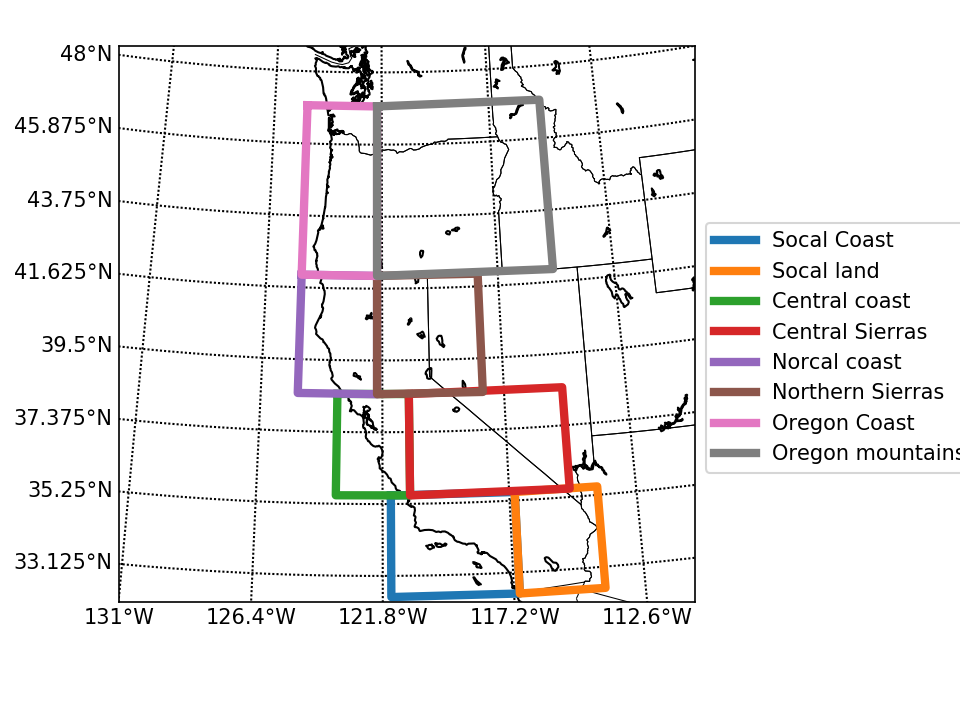

In [44]:
fig, ax = plt.subplots(1,1)
m = make_map(ax)
for i,r in enumerate(rgs):
    m.plot([r[0][1],r[1][1],r[1][1],r[0][1],r[0][1]],[r[1][0],r[1][0],r[0][0],r[0][0],r[1][0]],
           latlon=True,label=lbls[i],lw=4)
plt.legend(bbox_to_anchor=[1.0,0.7])
plt.tight_layout(rect=[0.1,-0.4,0.95,1.5])